## make pre- and post-CE evolution separations

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
import glob
import time
import math
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from termcolor import colored
from COSMIClib import *
# parallelization stuff
from joblib import Parallel, delayed
import multiprocessing
import subprocess
import h5py

ModuleNotFoundError: No module named 'termcolor'

In [3]:
folder = "/mnt/home/mrenzo/RUNS/try_cosmic/run_small_pop/default_qcrits/"
h5frame = glob.glob(folder+"*.h5")[0]
print(h5frame)

/mnt/home/mrenzo/RUNS/try_cosmic/run_small_pop/default_qcrits/dat_DeltaBurst_0_15_0_15.h5


In [4]:
with h5py.File(h5frame, 'r') as f:
    # List all groups
    print(f.keys())

<KeysViewHDF5 ['bcm', 'bin_state_nums', 'bpp', 'conv', 'idx', 'initCond', 'mass_binaries', 'mass_singles', 'mass_stars', 'match', 'n_binaries', 'n_singles', 'n_stars']>


In [5]:
conv = pd.read_hdf(h5frame, key='conv')
bpp =  pd.read_hdf(h5frame, key='bpp') # key evolutionary changes
# bcm =  pd.read_hdf(h5frame, key='bcm') # specific times (with the default init this is at the end of the evolution)
total_mass = pd.read_hdf(h5frame, key='mass_stars')


In [6]:
print(bpp.keys())


Index(['tphys', 'mass_1', 'mass_2', 'kstar_1', 'kstar_2', 'sep', 'porb', 'ecc',
       'RROL_1', 'RROL_2', 'evol_type', 'Vsys_1', 'Vsys_2', 'SNkick',
       'SNtheta', 'aj_1', 'aj_2', 'tms_1', 'tms_2', 'massc_1', 'massc_2',
       'rad_1', 'rad_2', 'bin_num'],
      dtype='object')


In [38]:
iCEinit = bpp.evol_type == 7 # select systems at the beginning of the CE
# print(bpp.sep[iCEinit])

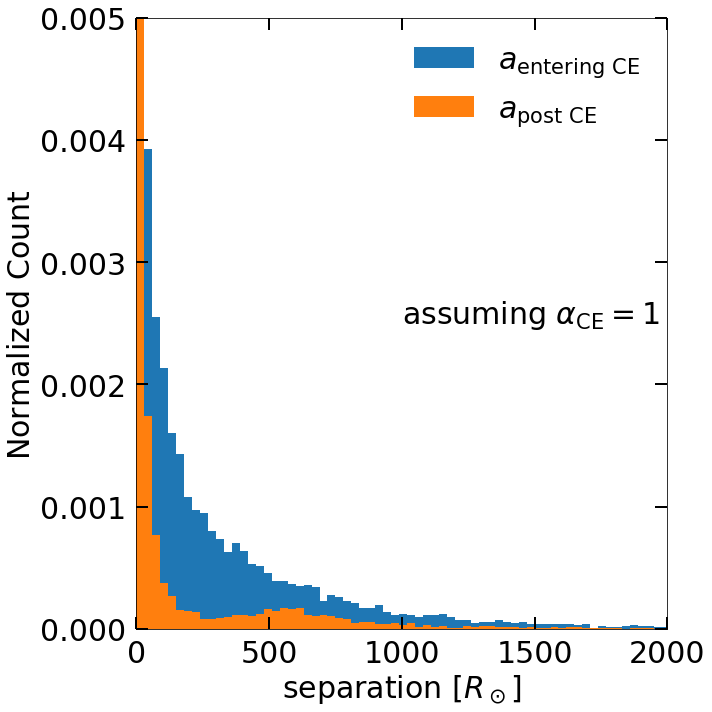

In [8]:
fig=plt.figure(figsize=(10, 10.))
ax=fig.add_subplot(111)

a0 = bpp.sep[iCEinit]
afinal = bpp.sep[iCEend]
# N, B_edges = np.histogram(a0, bins=10, range=(0,3000), normed=True)
ax.hist(a0, bins=100, range=(0,3000), density=True, label="$a_\mathrm{entering\ CE}$")
ax.hist(afinal, bins=100, range=(0,3000), density=True, label="$a_\mathrm{post\ CE}$")
ax.text(0.5,0.5, r"assuming $\alpha_\mathrm{CE}=1$", fontsize=30, transform=ax.transAxes)
ax.set_xlim(0,2000)
ax.set_xlabel(r"$\mathrm{separation} \ [R_\odot]$", fontsize=30)
ax.set_ylabel(r"$\mathrm{Normalized\ Count}$", fontsize=30)
ax.set_ylim(0,0.005)
ax.tick_params(axis='both', which='major', width=2, top="on", right="on",
               length=12, pad=10, labelsize=30, direction='in')
ax.tick_params(axis='both', which='minor', width=2, top="on", right="on",
               length=6, pad=10, direction='in')
l=ax.legend(loc="best", fontsize=30)
l.draw_frame(False)
# ax.xaxis.set_major_locator(MultipleLocator(5))
# ax.xaxis.set_minor_locator(MultipleLocator(1))
# ax.yaxis.set_major_locator(MultipleLocator(5))
# ax.yaxis.set_minor_locator(MultipleLocator(1))
plt.tight_layout()
plt.savefig(folder+"/separations.png", dpi=300)


min, max afinal 0.1598193688883472 4631.586849991462
min max m_GW emitting 0.15813707110863445 34.09120435454504


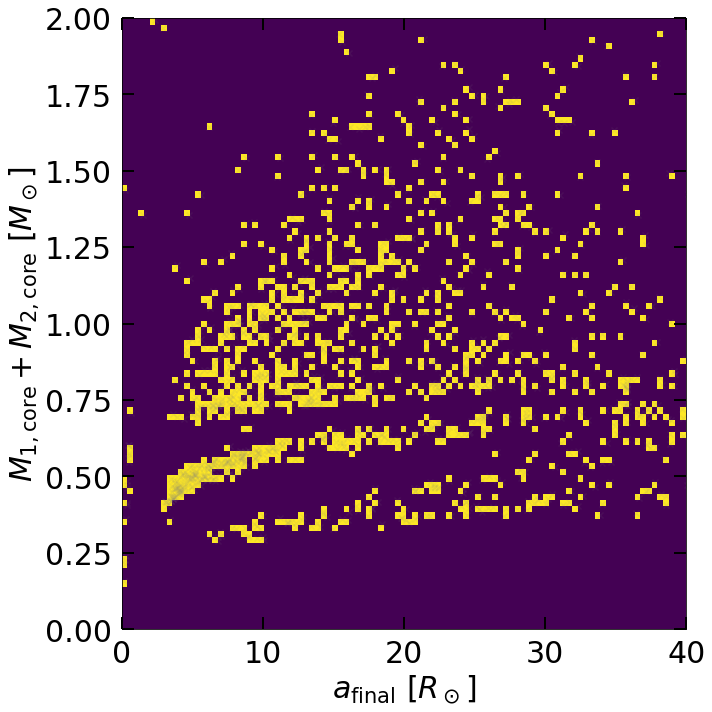

In [40]:
iCEend = bpp.evol_type == 8 #  select systems at the end of the CE
iCEdoublecore = (bpp.evol_type == 8) & ((bpp.kstar_1>1) & (bpp.kstar_2>1)) # end of CE for double core (exclude MS)

mc1 = bpp.massc_1[iCEdoublecore]
mc2 = bpp.massc_2[iCEdoublecore]
m_GWemitting = mc1+mc2
afinal = bpp.sep[iCEdoublecore]
print("min, max afinal",min(afinal),max(afinal))
print("min max m_GW emitting", min(m_GWemitting), max(m_GWemitting))
# havecores = m_GWemitting >= 0.01
# afinal = afinal[havecores]
# m_GWemitting = m_GWemitting[havecores]

fig=plt.figure(figsize=(10, 10.))
ax=fig.add_subplot(111)

# H, xedges, yedges = np.histogram2d(afinal,m_GWemitting, bins=100,range=[[0,2000],[0,5]],  normed=True)
# print(H.max(),H.min())
# X, Y = np.meshgrid(xedges, yedges)
# print(X)
# print(Y)
# ax.pcolormesh(X,Y,H) #, vmin=0, vmax=0.0005)

X = np.linspace(0,40,100)
Y = np.linspace(0,2,100)
mat = np.zeros((len(X),len(Y)))

for i in range(0,len(X)-1,1):
    # print("x", i, X[i])
    Nx =((afinal[:] >= X[i]) & (afinal[:] < X[i+1]))
    for j in range(0,len(Y)-1,1):
        # print("y", j, Y[j])
        Ny = ((m_GWemitting[:] >= Y[j]) & (m_GWemitting[:] < Y[j+1]))
        # print(Nx.sum(),Ny.sum())
        mat[j,i] = np.sum((Nx & Ny))
        # print(mat[j,i])
# print(mat.max(), mat.min())
p = ax.pcolor(X,Y,mat, vmin=0, vmax=mat.max()*0.1)

ax.scatter(afinal, m_GWemitting, c='#808080', marker='x',alpha=0.1)
ax.set_xlim(0,40)
ax.set_ylim(0,2)
ax.set_xlabel(r"$a_\mathrm{final} \ [R_\odot]$", fontsize=30)
ax.set_ylabel(r"$M_{1,\mathrm{core}}+M_{2,\mathrm{core}} \ [M_\odot]$", fontsize=30)
ax.tick_params(axis='both', which='major', width=2, top="on", right="on",
               length=12, pad=10, labelsize=30, direction='in')
ax.tick_params(axis='both', which='minor', width=2, top="on", right="on",
               length=6, pad=10, direction='in')
plt.tight_layout()
plt.savefig(folder+'/afinal_M_gw_emitting.pdf')

0.001 1.826776866181126e-18


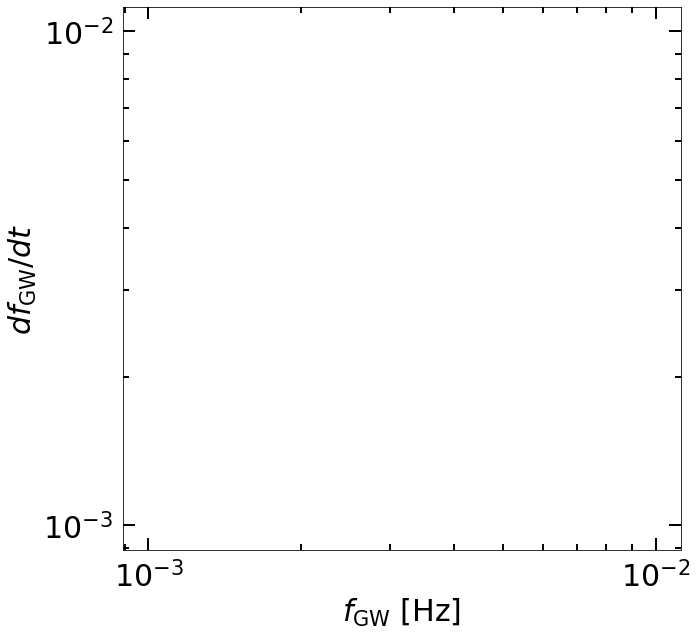

In [95]:
## fdot vs f
fig=plt.figure(figsize=(10, 10.))
ax=fig.add_subplot(111)
ax.set_xlabel(r"$f_\mathrm{GW}$ [$\mathrm{Hz}$]", fontsize=30)
ax.set_ylabel(r"$df_\mathrm{GW}/dt$", fontsize=30)


ax.tick_params(axis='both', which='major', width=2, top="on", right="on",
               length=12, pad=10, labelsize=30, direction='in')
ax.tick_params(axis='both', which='minor', width=2, top="on", right="on",
               length=6, pad=10, direction='in')

def dotf_gw(f_gw, Mchirp=0.5):
    # define constants
    G_cgs = 6.67428e-8 # in cgs from MESA
    c = 2.99792458e10 # in cm/s from MESA
    Msun = Msun = 1.9892e33 # form MESA in g
    pi = math.pi
    # -------------------
    # assumes f_gw in HZ
    # -------------------
    # from Peters formula
    prefactor = (96.0/5.0)
    prefactor *= pow(pi,8.0/3.0)
    # print(prefactor, "=(96/5)pi^8/3")
    prefactor *= pow(c,-5.0)
    # print(prefactor, "=(96/5)pi^8/3/c^5")
    chirp_term = pow(G_cgs*Mchirp*Msun,5.0/3.0)
    # print(chirp_term, "chirp term cgs")
    # print("chirp_term",chirp_term, "prefactor*chirp_term", prefactor*chirp_term)
    dotf_gw = prefactor*chirp_term*pow(f_gw,11.0/3.0)
    # print("dot_gw",dotf_gw)
    return dotf_gw

f_gw = 1e-3 #np.linspace(1e-5,1e-1)
print(f_gw, dotf_gw(f_gw))
ax.scatter(f_gw,dotf_gw(f_gw), lw=3, c='b')
ax.set_xscale('log')
ax.set_yscale('log')

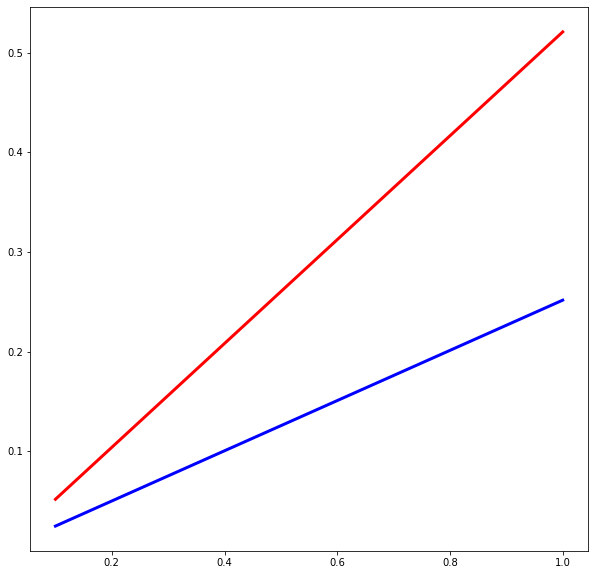

In [13]:

def Roche_radii(M1, M2, a):
    # Eggleton 1983 formula for Roche Lobe
    q = M1/M2
    rl1 = a*((0.49*q**(2/3.0))/(0.6*q**(2/3.0)+np.log(1+q**(1/3.0))))
    q = M2/M1
    rl2 = a*((0.49*q**(2/3.0))/(0.6*q**(2/3.0)+np.log(1+q**(1/3.0))))
    return rl1, rl2

def Kepler_getFrequency(M1, M2, a):
    Msun = 1.99e33  # g
    Rsun = 6.99e10  # cm
    G = 6.67e-8  # cgs: cm^3 g^-1 s^-2
    M1 *= Msun      # g
    M2 *= Msun      # g
    # assumes a is in solar raddii
    omega = np.sqrt((G*(M1+M2)*Msun)/(a*Rsun)**3)
    f = omega/(2*math.pi)
    return f

fig=plt.figure(figsize=(10, 10.))
ax=fig.add_subplot(111)
separations = np.linspace(0.1,1,100)
rl1, rl2 = Roche_radii(0.5,0.1,separations)
#ax.plot(separations,rl1,ls='--')
ax.plot(separations, rl1, "r", lw=3)
ax.plot(separations, rl2, "b", lw=3)


Text(0, 0.5, 'Roche Radii (Rsun)')

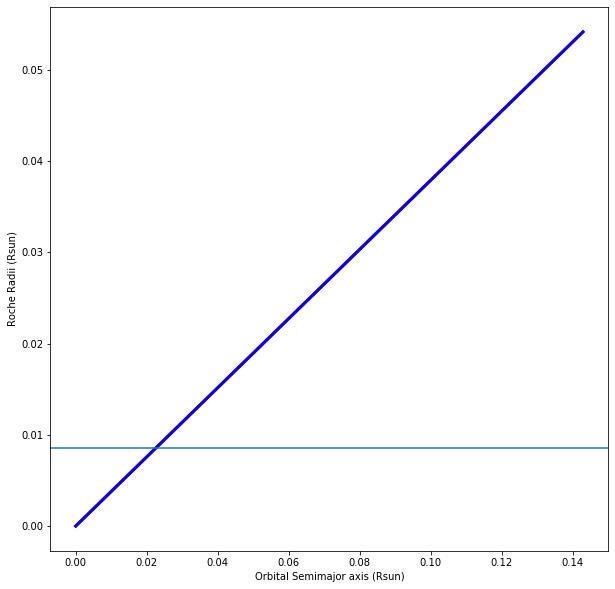

In [18]:
# Meters
Rsun = 7e8
orbital_seps = np.linspace(0.,1e8,100)

# Meters
roche1,roche2 = Roche_radii(0.5,0.5,orbital_seps)

fig=plt.figure(figsize=(10, 10.))
ax=fig.add_subplot(111)
rl1, rl2 = Roche_radii(0.5,0.1,separations)
#ax.plot(separations,rl1,ls='--')
ax.plot(orbital_seps/Rsun, roche1/Rsun, "r", lw=3)
ax.plot(orbital_seps/Rsun, roche2/Rsun, "b", lw=3)
ax.axhline(y=6e6/Rsun)
ax.set_xlabel('Orbital Semimajor axis (Rsun)')
ax.set_ylabel('Roche Radii (Rsun)')